# Exploration of local defocus shifts as a particle rejection criterion
This exploration was motivated by olibclarke's question at https://discuss.cryosparc.com/t/11632/5.

## Required
- Exposures with estimated `ctf/df1_A` values
- Particles with refined `ctf/df1_A` values
- A file with _valid_ CryoSPARC instance (connection) information like
  ```yaml
  license: 682437fb-d6ae-47b8-870b-b530c587da94
  host: localhost
  base_port: 39000
  email: username@email.server
  password: top7secret-phrase
  ```
  Actual values must correspond to the relevant CryoSPARC instance and CryoSPARC UI login information.
- a python environment with, aside from cryosparc-tools
  - pandas
  - matplotlib

In [23]:
%matplotlib inline
from cryosparc.tools import CryoSPARC
import cryosparc.dataset
import pandas
import matplotlib.pyplot as plt
import yaml

instance_info_file = '/tmp/release.yaml' # as described above

with open(instance_info_file, 'r') as yh:
    cs = CryoSPARC(**yaml.safe_load(yh))

## Input data

`J4` and `J17` are completed _Patch CTF_ and _Home Refine_ jobs from a run of the [benchmark workflow](https://guide.cryosparc.com/setup-configuration-and-management/software-system-guides/tutorial-verify-cryosparc-installation-with-the-extensive-workflow-sysadmin-guide) based on a subset of [EMPIAR-10025](https://doi.org/10.6019/EMPIAR-10025) movies.

In [25]:
project = cs.find_project('P44')
ctf_job = project.find_job('J4')
refine_job = project.find_job('J17')

For convienience, loaded datasets are converted to `pandas.DataFrame`s. The exposures dataset's index is [converted to a an `index` column](https://stackoverflow.com/a/20461206) for use in plotting, later

In [26]:
exposures_df = pandas.DataFrame(ctf_job.load_output('exposures').rows()
                               ).reset_index()
refine_particles_df = pandas.DataFrame(refine_job.load_output('particles').rows())

and joined on the exposure UIDs.

In [28]:
joined = refine_particles_df.merge(right=exposures_df, left_on='location/micrograph_uid',
                                   right_on='uid', suffixes=('.particle', '.exposure'))

## Hypothesis
Removal of particles with (absolute) shifts in their refined defocus values will result in a higher resolution reconstruction. Please refer to https://discuss.cryosparc.com/t/11632/5 for the olibclarke's actual intent.

In [29]:
joined['ctf/df1_A_diff'] = joined['ctf/df1_A.particle'] - joined['ctf/df1_A.exposure']

## Exploration

Shift distribution over entire dataset:

In [30]:
joined['ctf/df1_A_diff'].describe()

count    11736.000000
mean        67.377121
std        158.292664
min       -808.642578
25%        -18.759766
50%         69.953613
75%        166.506836
max        648.212891
Name: ctf/df1_A_diff, dtype: float64

and per ctf-estimated exposure:

0          Axes(0.1,0.15;0.0336134x0.75)
1     Axes(0.140336,0.15;0.0336134x0.75)
2     Axes(0.180672,0.15;0.0336134x0.75)
3     Axes(0.221008,0.15;0.0336134x0.75)
4     Axes(0.261345,0.15;0.0336134x0.75)
5     Axes(0.301681,0.15;0.0336134x0.75)
6     Axes(0.342017,0.15;0.0336134x0.75)
7     Axes(0.382353,0.15;0.0336134x0.75)
8     Axes(0.422689,0.15;0.0336134x0.75)
9     Axes(0.463025,0.15;0.0336134x0.75)
10    Axes(0.503361,0.15;0.0336134x0.75)
11    Axes(0.543697,0.15;0.0336134x0.75)
12    Axes(0.584034,0.15;0.0336134x0.75)
13     Axes(0.62437,0.15;0.0336134x0.75)
14    Axes(0.664706,0.15;0.0336134x0.75)
15    Axes(0.705042,0.15;0.0336134x0.75)
16    Axes(0.745378,0.15;0.0336134x0.75)
17    Axes(0.785714,0.15;0.0336134x0.75)
18     Axes(0.82605,0.15;0.0336134x0.75)
19    Axes(0.866387,0.15;0.0336134x0.75)
dtype: object

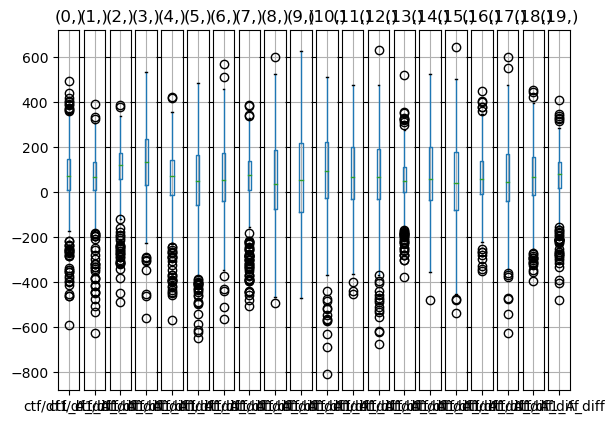

In [31]:
by_exposure = joined.groupby(['index'])
by_exposure.boxplot(column='ctf/df1_A_diff', layout=(1,20))

Ugly, but "cheap" (single command) plots encourage a test discarding particles of their defocus shifted outside the (-50&Aring;, +200&Aring;) interval and save retained particles.

In [36]:
selected_neg50_pos200 = (joined['ctf/df1_A_diff'] > -50) & (joined['ctf/df1_A_diff'] < 200)
print(f"Selected {sum(selected_neg50_pos200)} within defocus shift limits.")
selected_particle_dataset = refine_job.load_input('particles').mask(selected_neg50_pos200)
project.save_external_result(workspace_uid='W7', type='particle',
                             dataset=selected_particle_dataset)

Selected 7361 within defocus shift limits.


'J49'

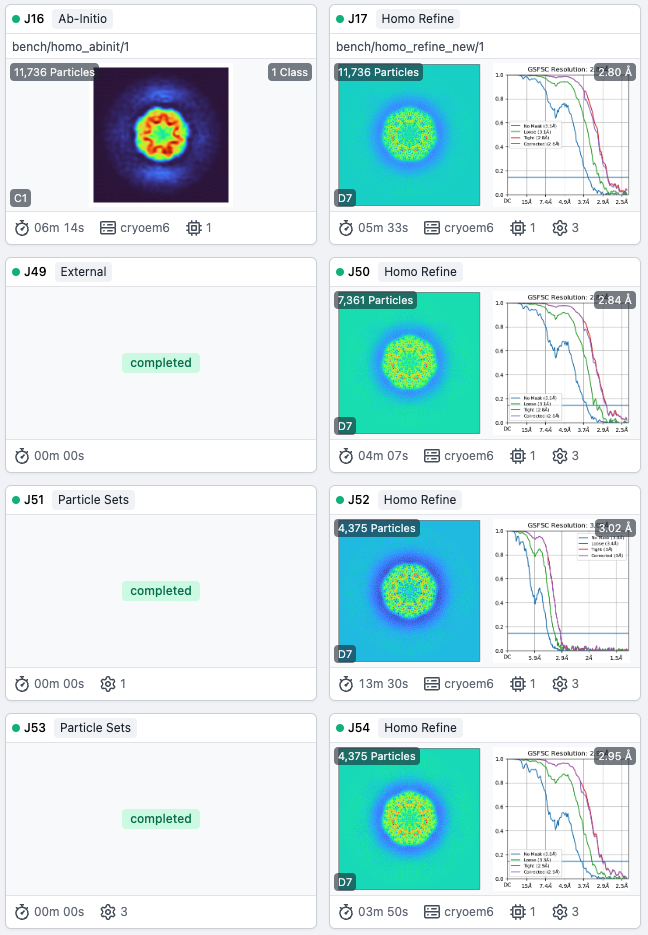

`J17:` Refinement from benchmark workflow: 11,736 particles, 2.80 &Aring; resolution.

`J50:` Refinement of particles within the allowed shift range: 7,361, 2.84 &Aring;.

`J52:` Refinement of particles outside the allowed shift range: 4,375, 3.02 &Aring;.

`J54:` Refinement of a random subset of particles within the allowed shift range: 4,375, 2.95 &Aring;.

The results are _nearly_ bad enough to reject the hypothesis. Things to try: 
- check if the code indeed rejected particles with larger shifts
- use shift w.r.t. mean refined defocus either within exposure or across all exposures
- use a scaled version of the shift as a rejection criterion
- ...